# General Exploration

This notebook contains code used to analyse the relationships between categories using TF-IDF and Word2vec embeddings as well as different clustering methods. For the interpretation of results, see the project report. Note that the data was merged from different datasets to ensure that we have 19 more equally represented categories than if we were to take just one dataset as we did in **iberEvalExploration.ipynb**. Note also that most figures in the final report are taken from this notebook.

In [1]:
# import used python libraries:
import pandas as pd
import numpy as np
import json
import nltk
import string
import re
import sys
sys.path.append("../")
from scripts.start import iberEval, sexists
from scripts.data_utils import get_balanced_data
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans, AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score, v_measure_score, completeness_score, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.cm as cm
from collections import Counter
import gensim.downloader as api
from scipy.cluster.hierarchy import dendrogram, ward, single, complete, average, weighted, centroid, median
from scipy.cluster import hierarchy
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# 1. Reading the data

In [4]:
# read balanced data from merged_data.csv
tweets,categories,sources = get_balanced_data(500)
dfCat = pd.DataFrame(categories, columns=["category"]).astype('category')
catCodes = dfCat['category'].cat.codes

# make sure all the tweets are Strings:
for i in range(len(tweets)):
    tweets[i] = str(tweets[i])

# show how the classes are represented
Counter(categories)

Counter({'cyberbullying': 355,
         'offensive': 500,
         'spam': 500,
         'abusive': 500,
         'hateful': 500,
         'profane': 500,
         'discredit': 500,
         'sexual_harassment': 410,
         'derailing': 29,
         'stereotype': 137,
         'dominance': 49,
         'obscene': 500,
         'insult': 500,
         'threat': 478,
         'racist': 500,
         'homophobic': 500,
         'benevolent sexism': 500,
         'hostile sexism': 500,
         'vulgar': 500})

# 2. Exploration with the TF-IDF embeddings

## 2.1. Exploration of individual tweets with TF-IDF embeddings

### 2.1.1. Generating TF-IDF embeddings

In [5]:
# tokenizer to be used by the vectorizer
def tokenize_and_lemmatize(text):
    text = re.sub("[@]\w+", "", text) # remove tags
    text = re.sub("<user>", "", text, flags=re.IGNORECASE) # remove <USER> tags
    text = re.sub("<url>", "", text, flags=re.IGNORECASE) # remove <URL> tags
    # remove punctuation
    table = text.maketrans({key: None for key in string.punctuation})
    text = text.translate(table)
    text = re.sub("(http)\w+", "", text) # remove links
    tokens = nltk.word_tokenize(text)
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation).
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    # lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return filtered_tokens


# stopwords to be used by the vectorizer
englishwords = stopwords.words('english')
englishwords.extend(["u","rt","im","em","q","na","wan","’","“","”","…"])
englishwords.extend(tokenize_and_lemmatize(" ".join(englishwords)))
# lemmatizer = WordNetLemmatizer() # did not improve our results


# The vectorizer using the tokenizer and prepared stopwords
tfidf_vec = TfidfVectorizer(max_df=0.95, 
                        max_features=10000,
                        min_df=10, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,1))

In [6]:
# get tf-idf representation of tweets with the vectorizer

tfidf_mat = tfidf_vec.fit_transform(tweets)
tfidf_mat.shape # 7958 tweets represented with 1166 attributes

(7958, 1166)

### 2.1.2. Clustering TF-IDF embeddings of each tweet

In [126]:
# cluster the tf-idf embeddings of tweets ( takes less than a minute )

clusters = KMeans(n_clusters=19, random_state=20).fit_predict(tfidf_mat)

# alternative clustering methods tried:
# clusters = MiniBatchKMeans(n_clusters=19, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_mat)
# clusters = SpectralClustering(n_clusters=19, random_state=20).fit_predict(tfidf_mat)

# show the decreasing sizes of the resulting clusters.
Counter(clusters).most_common()

[(0, 3330),
 (1, 467),
 (3, 432),
 (6, 418),
 (8, 365),
 (15, 337),
 (14, 328),
 (5, 326),
 (4, 305),
 (16, 249),
 (10, 246),
 (18, 226),
 (17, 200),
 (9, 197),
 (11, 157),
 (13, 104),
 (7, 103),
 (2, 95),
 (12, 73)]

In [159]:
# Evaluating which categories make most sense according to the V-Score based on cluster predictions
v_measures = []
for i in range(19):
    arCopy = np.array(catCodes.copy())
    arCopy[np.where(catCodes != i)] = -1
    v_measures.append(v_measure_score(arCopy, clusters))
    
print("Decreasing ordering of the categories according to the V-Score based on cluster predictions:\n")
print(" "*18+"| V measure |  Completeness | Homogeneity |")
for i in np.argsort(v_measures)[::-1]:
    arCopy = np.array(catCodes.copy())
    arCopy[np.where(catCodes != i)] = -1
    print("-"*60+"|\n"+"{:<17}".format(np.unique(categories)[i]) + " |    "+
          format(   v_measure_score(arCopy, clusters), ".4f")   + " |        "+ 
          format(completeness_score(arCopy, clusters), ".4f")   + " |      "+
          format( homogeneity_score(arCopy, clusters), ".4f") + " |")

Decreasing ordering of the categories according to the V-Score based on cluster predictions:

                  | V measure |  Completeness | Homogeneity |
------------------------------------------------------------|
racist            |    0.1001 |        0.0552 |      0.5391 |
------------------------------------------------------------|
homophobic        |    0.0945 |        0.0521 |      0.5090 |
------------------------------------------------------------|
profane           |    0.0865 |        0.0477 |      0.4659 |
------------------------------------------------------------|
benevolent sexism |    0.0810 |        0.0447 |      0.4365 |
------------------------------------------------------------|
abusive           |    0.0390 |        0.0215 |      0.2104 |
------------------------------------------------------------|
spam              |    0.0368 |        0.0203 |      0.1980 |
------------------------------------------------------------|
offensive         |    0.0264 |       

### 2.1.3. Visualizing TF-IDF embeddings  of each tweet

In [160]:
# Differing plotting methods

def plot_tsne(data, labels, defLabels=None, plotlabels=None):
    max_label = max(labels)
    
    pca = PCA(n_components=2, random_state=2).fit_transform(data.todense())
    tsne = TSNE(random_state=5).fit_transform(PCA(n_components=50, random_state=2).fit_transform(data.todense()))
    
    label_subset = labels
    f, ax = plt.subplots(1, 1, figsize=(16, 7))
    pts2 = ax.scatter(tsne[:, 0], tsne[:, 1], c=label_subset, cmap="jet", alpha=0.5)
    ax.set_xlim(left=-92,right=110)

    if defLabels is None:
        ax.legend(*pts2.legend_elements(num=None), loc='lower right')
    else:
        ax.legend(pts2.legend_elements(num=None)[0], defLabels, loc='lower right')

    return ax, f

def plot_tsne_pca(data, labels,defLabels=None):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)

    pca = PCA(n_components=2).fit_transform(data.todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data.todense()))
    label_subset = labels

    f, ax = plt.subplots(1, 2, figsize=(26, 11))
    pts = ax[0].scatter(pca[:, 0], pca[:, 1], c=label_subset, cmap="jet")
    ax[0].set_title('PCA Cluster Plot')
    pts2 = ax[1].scatter(tsne[:, 0], tsne[:, 1], c=label_subset, cmap="jet")
    ax[1].set_title('TSNE Cluster Plot')
    if defLabels is None:
        ax[0].legend(*pts.legend_elements(num=None))
        ax[1].legend(*pts2.legend_elements(num=None))
    else:
        ax[0].legend(pts.legend_elements(num=None)[0], defLabels)
        ax[1].legend(pts2.legend_elements(num=None)[0], defLabels)
    plt.show()
        
def plot_lda(data, labels, defLabels=None, plotlabels=None):
    lda = LDA(n_components=2).fit_transform(data.todense(), y=labels)
    label_subset = labels
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    pts2 = ax.scatter(lda[:, 0], lda[:, 1], c=label_subset, cmap="jet", alpha=0.5)
    legendItems = pts2.legend_elements(num=None)[0]

    plotLegendItems = []
    for ix in range(len(plotlabels)):
        ixs = np.where(defLabels == plotlabels[ix])[0][0]
        plotLegendItems.append(legendItems[ixs])
    
    ax.set_title('LDA Plot')
    ax.legend(plotLegendItems, plotlabels, loc='lower left', fontsize="13")
    return ax, f

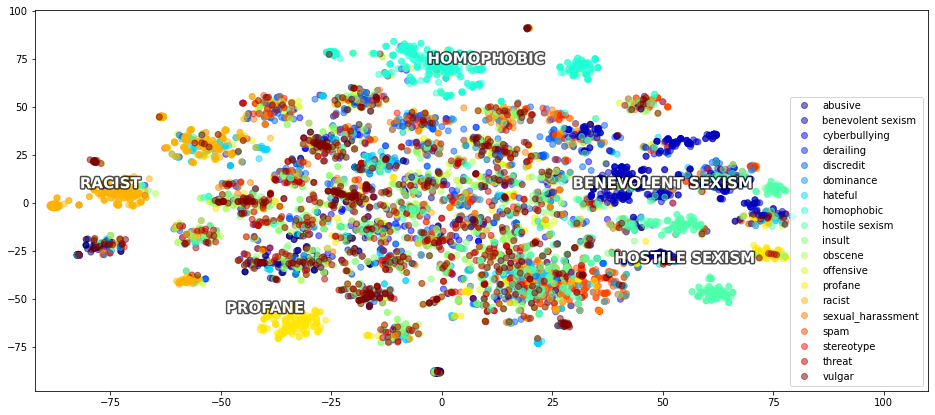

In [78]:
ax,f = plot_tsne(tfidf_mat, catCodes, np.unique(categories), np.unique(categories) )
# ax.annotate("racist".upper(), alpha=1.0, xy=(0,-75), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("hostile sexism".upper(), alpha=1.0, xy=(55,-29), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("profane".upper(), alpha=1.0, xy=(-40,-55), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
# ax.annotate("vulgar".upper(), alpha=1.0, xy=(25,-70), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("benevolent sexism".upper(), alpha=1.0, xy=(50,10), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("homophobic".upper(), alpha=1.0, xy=(10,75), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("racist".upper(), alpha=1.0, xy=(-75,10), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
plt.show()

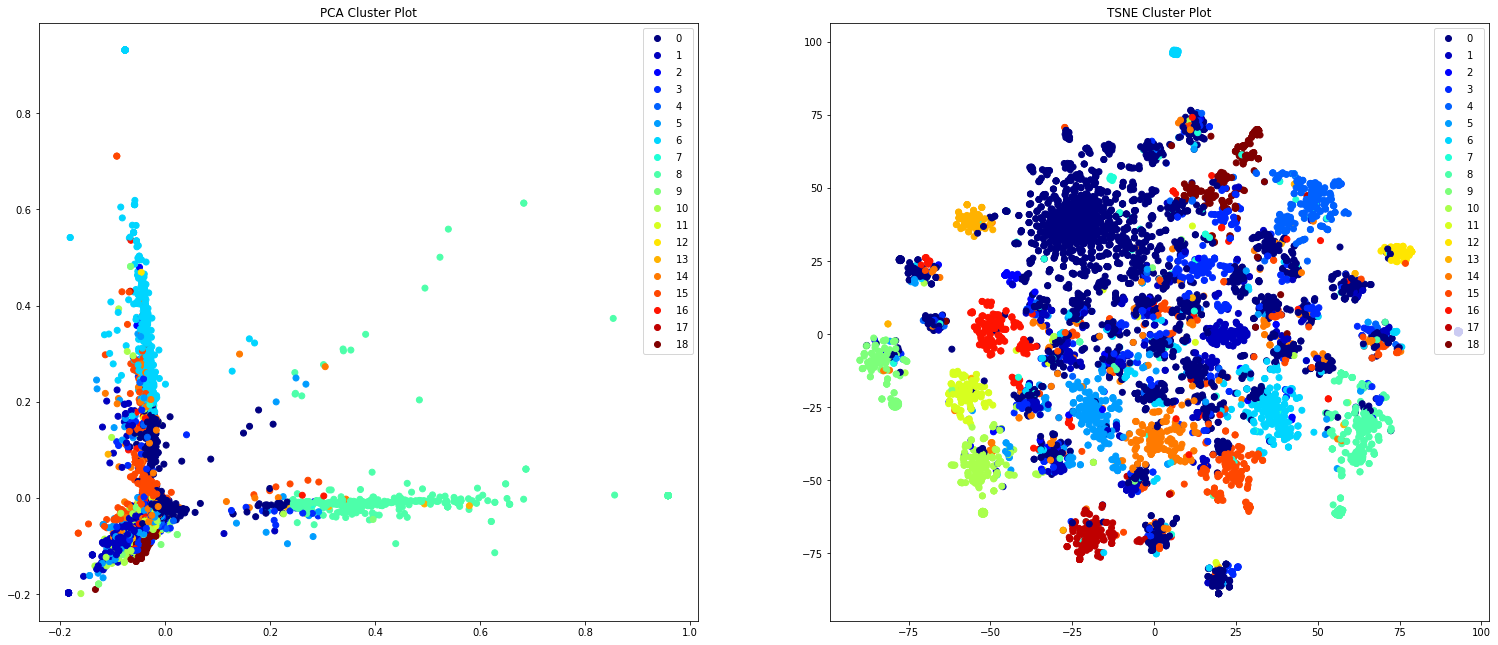

In [79]:
plot_tsne_pca(tfidf_mat, clusters)

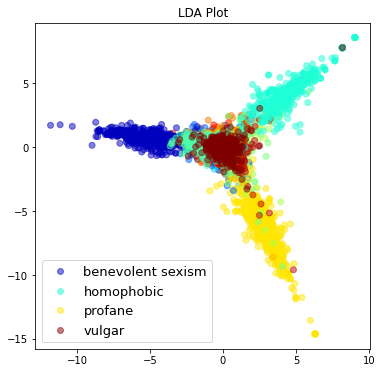

In [116]:
plot_lda(tfidf_mat, catCodes, np.unique(categories), ["benevolent sexism", "homophobic", "profane", "vulgar"])
plt.show()

### 2.1.4. Extracting most representative words using TF-IDF embeddings

In [161]:
# get k most important keywords for each group

def get_top_keywords(data, clusters, labels, k, categoryNames=None):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        if categoryNames is None:
            print('\nCluster {}'.format(i))
        else:
            print('\nCluster {}'.format(categoryNames[i]))
        print(', '.join([labels[t] for t in np.argsort(r)[-k:]][::-1]))

# get 10 most representative keywords for each cluster
get_top_keywords(tfidf_mat, clusters, tfidf_vec.get_feature_names(), k=10)


Cluster 0
fucked, get, dyke, know, go, one, idiot, want, hell, amp

Cluster 1
bitch, dick, stupid, get, hoe, pussy, suck, got, lol, aint

Cluster 2
niggas, cold, flourish, separate, happens, yo, food, yall, hate, self

Cluster 3
like, man, bitch, look, act, people, one, looks, think, fucking

Cluster 4
women, men, sexist, womensday, rape, adaywithoutwomen, amp, like, notsexist, without

Cluster 5
ass, bitch, get, stupid, ugly, pussy, fuck, like, fucking, hoe

Cluster 6
fucking, hate, know, racist, cant, go, people, get, stupid, want

Cluster 7
us, love, women, syria, like, men, know, help, trying, tell

Cluster 8
faggot, see, look, called, use, fucking, sissy, straight, like, fuck

Cluster 9
nigger, fuck, get, say, see, shut, call, black, white, called

Cluster 10
nigga, like, said, bitch, fuck, got, hate, aint, mad, money

Cluster 11
bitches, hate, shit, like, bitch, dick, yall, bad, got, fuck

Cluster 12
dickhead, really, fuck, like, next, door, guy, double, one, attention

Cluster 

In [162]:
# get k most representative keywords for each category:

get_top_keywords(tfidf_mat, catCodes, tfidf_vec.get_feature_names(), 10, np.unique(categories))


Cluster abusive
fucking, fucked, bad, ass, like, cant, idiot, hate, bitch, go

Cluster benevolent sexism
man, woman, love, womensday, like, women, girl, good, without, adaywithoutwomen

Cluster cyberbullying
bra, get, know, bitch, fake, like, fuck, shit, lol, stop

Cluster derailing
women, rape, woman, men, lol, bitch, whore, dick, dress, every

Cluster discredit
bitch, stupid, whore, hoe, girl, slut, women, like, pussy, ass

Cluster dominance
bitch, women, like, whore, yesallmen, men, girl, cock, shut, dick

Cluster hateful
niggas, hate, nigga, fucking, idiot, like, mad, people, amp, idiots

Cluster homophobic
faggot, dyke, look, see, like, called, gay, straight, sissy, big

Cluster hostile sexism
sexist, mkr, women, kat, notsexist, girls, female, call, men, think

Cluster insult
fuck, fucking, go, wikipedia, shit, page, like, get, suck, ass

Cluster obscene
fuck, fucking, go, suck, get, shit, page, wikipedia, asshole, ass

Cluster offensive
bitch, bitches, hoes, pussy, hoe, like, fu

**Some clusters are clearly distinct and seem to match some categories: Examples Are:**
* **cluster 1  and benevolent sexism**
* **cluster 4  and homophobic**
* **cluster 13 and profane**

## 2.2. Exploring categories represented with TF-IDF embeddings

### 2.2.1. Grouping tweets into categories

In [8]:
# group tweets by category
uniquecategories = np.unique(categories)
tweetsNP = np.array(tweets)
tweetsByCategory = []
for i in range(len(uniquecategories)):
    indices = np.where(np.array(categories) == uniquecategories[i])
    tweetsByCategory.append(" ".join(list(tweetsNP[indices])))

# shorten category names 
uniquecategories = np.array(["benevolent" if c == "benevolent sexism" else 
                             "hostile" if c == 'hostile sexism' else 
                             "harassment" if c == 'sexual_harassment' else c for c in uniquecategories])

### 2.2.2. Generating TF-IDF embeddings for each category 

In [9]:
# modify the vectorizer
tfidf_vec_2 = TfidfVectorizer(max_df=1.0,
                        max_features=10000,
                        min_df=3, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,1))

# generate Tfidf representations for each category using the modified vectorizer and grouped tweets
tfidf_mat3 = tfidf_vec_2.fit_transform(tweetsByCategory)
tfidf_mat3.shape # The 19 categories are represented with 3250 Tfidf values

(19, 3250)

### 2.2.3. Visualizing similarities of categories using TF-IDF embeddings 

In [10]:
# get cosine similarity matrix

documentVectors = tfidf_mat3.todense() # the vectors are already normalized
# documentVectors = documentVectors / np.linalg.norm(documentVectors, axis=1).flatten()

# the pairwise dot product of normalized vectors gives us a matrix of cosine similarities
similarities = documentVectors.dot(documentVectors.T)
similarities.shape # the matrix shows pairwise similarities between the 19 categories.

(19, 19)

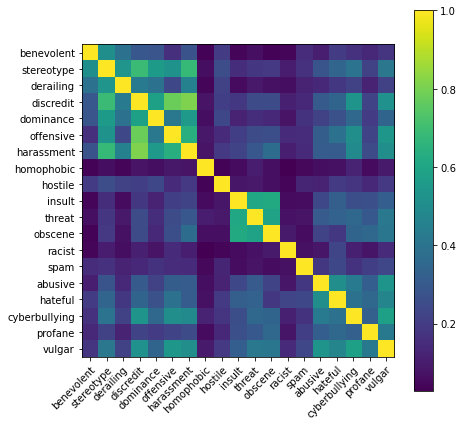

In [12]:
# cluster the 19 categories using affinity propagation 
ap = AffinityPropagation(affinity='precomputed', damping=0.51, random_state=None).fit(similarities)

# sort the labels and similarity matrix according to the results of affinity propagation
ixs = np.argsort(ap.labels_)
simsorted = similarities[ixs,:][:,ixs]
uniquecatssorted = uniquecategories[ixs]

# plot the sorted similarity matrix
fig, ax = plt.subplots(figsize=(7,7))
heatmap = plt.imshow(simsorted)
ax.set_yticks(np.arange(len(uniquecatssorted)))
ax.set_yticklabels(uniquecatssorted)
ax.set_xticks(np.arange(len(uniquecatssorted)))
ax.set_xticklabels(uniquecatssorted)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(heatmap)
plt.show()

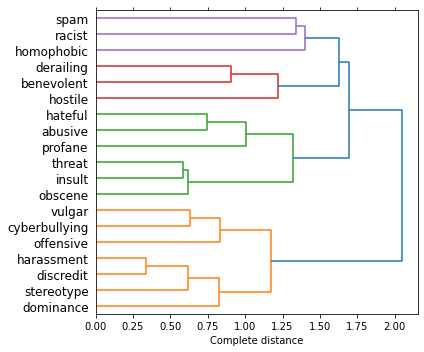

In [186]:
# hierarchical clustering using complete linkage

# use complete linkage and cosine distances to plot the dendrogram
dists1 = 1-simsorted
linkg = hierarchy.linkage(dists1, 'complete') # OPTIONS: ward, single, average, weighted, centroid, median, complete
fig, ax = plt.subplots(figsize=(6, 5))
ax = dendrogram(linkg, orientation="right", labels=uniquecatssorted);
plt.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
plt.xlabel("Complete distance")
plt.tight_layout()
plt.show()

# 3. Exploration with the Word2vec embeddings

## 3.1. Word2vec embeddings generated independedly for each category

### 3.1.1. Generating Word2vec embeddings

In [8]:
# load the api
word2vec = api.load('word2vec-google-news-300')

In [14]:
# For each category, the 30 most representative keywords according to the TFIDF are used 
# to get the word2vec representations for the categories

documentVectors = np.zeros((300,19))
npFeatures = np.array(tfidf_vec_2.get_feature_names())
for i in range(19):
    row = np.array(tfidf_mat3.getrow(i).todense()).flatten()
    indices = row.argsort()[::-1][:30] # get 30 most representative keywords for each category
    print(uniquecategories[i], ":\n" + ', '.join(npFeatures[indices]), "\n")
    for ix in indices:
        if npFeatures[ix] in word2vec:
            # get the weighted average of their word2vec representations
            documentVectors[:,i] += word2vec[npFeatures[ix]] * row[ix]

abusive :
fucking, fucked, ass, like, bad, bitch, fuck, idiot, shit, idiots, want, get, know, hate, cant, people, go, bitches, yall, ugly, say, even, stop, thats, george, stupid, need, damn, bush, got 

benevolent :
woman, man, love, like, women, girl, good, amp, lucky, without, happy, intention, loving, every, first, last, strong, day, coward, world, men, think, beautiful, act, girls, wife, life, would, biggest, mother 

cyberbullying :
fake, bra, bitch, r, like, fucking, get, fuck, shit, know, ass, stop, ugly, go, life, ur, haha, okay, say, lol, hoe, stupid, face, one, suck, would, anonymous, people, pretty, think 

derailing :
women, woman, rape, bitch, forward, men, dumbass, sexism, assault, dick, come, yesallmen, birth, whore, like, pregnant, sexual, lol, dress, control, hole, girl, every, get, want, understand, sign, asked, cuz, free 

discredit :
bitch, hoe, like, whore, stupid, girl, ass, women, woman, pussy, slut, dick, fuck, bitches, cunt, get, shit, one, girlfriend, think, y

## 3.1.2. Visualizing similarities between categories

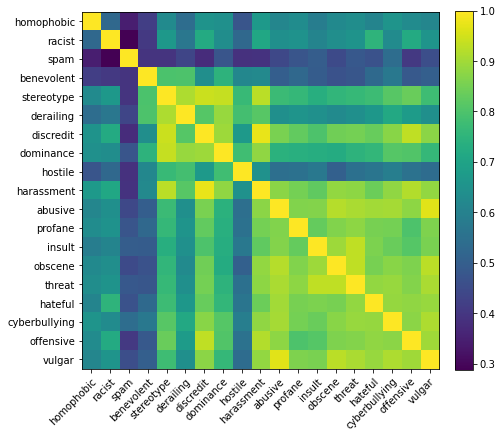

In [236]:
# normalize the vectors and get the cosine similarity matrix
documentVectors = documentVectors / np.linalg.norm(documentVectors, axis=0) # normalize the vectors
similarities = documentVectors.T.dot(documentVectors)  # get matrix of pairwise cosine similarities

# cluster the categories using afinity propagation
ap = AffinityPropagation(affinity='precomputed', damping=0.51, random_state=None).fit(similarities)
ixs = np.argsort(ap.labels_)
simsorted = similarities[ixs,:][:,ixs]
uniquecatssorted = uniquecategories[ixs]

fig, ax = plt.subplots()
heatmap = plt.imshow(simsorted)
fig.set_size_inches(7, 7)
ax.set_yticks(np.arange(len(uniquecatssorted)))
ax.set_yticklabels(uniquecatssorted)
ax.set_xticks(np.arange(len(uniquecatssorted)))
ax.set_xticklabels(uniquecatssorted)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(heatmap,fraction=0.046, pad=0.04)
plt.show()

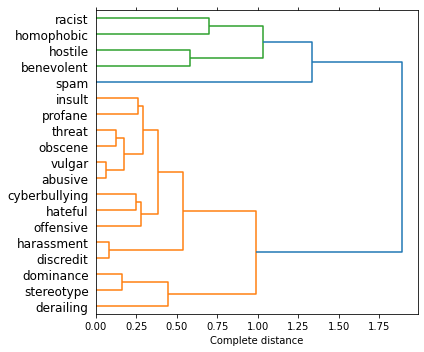

In [237]:
# hierarchical clustering using complete linkage

# use complete linkage and cosine distances to plot the dendrogram
dists1 = 1-simsorted
linkg = hierarchy.linkage(dists1, 'complete') # OPTIONS: ward, single, average, weighted, centroid, median, complete
fig, ax = plt.subplots(figsize=(6, 5))
ax = dendrogram(linkg, orientation="right", labels=uniquecatssorted);
plt.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
plt.xlabel("Complete distance")
plt.tight_layout()
plt.show()

## 3.2. Word2vec embeddings generated by always using the same 1137 words

This time, the words used to calculate Word2vec embeddings are not dependent on the category like in the previous subsection.

### 3.2.1. Generating Word2vec embeddings

In [238]:
# word2vec = api.load('word2vec-google-news-300')

# make sure the words of the TF-IDF embeddings are also contained in the word2vec by extending stopwords.
words = tfidf_vec.get_feature_names()
notInVocab = [w not in word2vec for w in words]
englishwords.extend(list(np.array(words)[notInVocab]))

tfidf_vec_3 = TfidfVectorizer(max_df=0.9, 
                        max_features=10000,
                        min_df=10, 
                        stop_words=englishwords, # extended stopwords !
                        tokenizer=tokenize_and_lemmatize,
                        norm='l1',
                        use_idf=False,
                        ngram_range=(1,1))

# get TF-IDF embeddings for each tweet.
tfidf_mat = tfidf_vec_3.fit_transform(tweets)
tfidf_mat.shape # the 7958 tweets are represented with 1137 TF-IDF attributes.

(7958, 1137)

In [239]:
# get the word2vec embeddings of the TF-IDF ebeddings
allwords = tfidf_vec_3.get_feature_names()
print(len(allwords))
wordvectors = np.zeros((len(allwords),300))
for i in range(len(allwords)):
    wordvectors[i,:] = word2vec[allwords[i]]
    
docVectors = np.dot(tfidf_mat.todense(),wordvectors)
docVectors.shape # the 7958 tweets are represented with 300 word2vec attributes

1137


(7958, 300)

In [225]:
# average the dotVectors to get one vector per category 
categoryVectors = np.zeros((19,300))
for i in range(19):
    categoryVectors[i,:] = np.array(np.mean(docVectors[np.where(catCodes == i)[0],:],axis=0)).flatten()

# calculate the similarity matrix 
documentVectors = (np.array(categoryVectors).T / np.linalg.norm(categoryVectors, axis=1)).T # normalize vectors
similarities = documentVectors.dot(documentVectors.T)   # matrix of pairwise cosine similarities
similarities.shape

(19, 19)

### 3.2.2. Visualizing similarities between categories

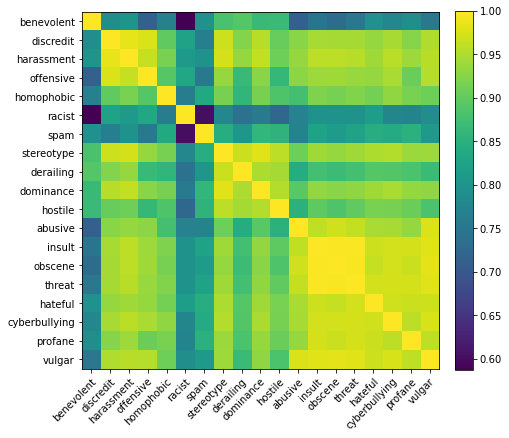

In [226]:
ap = AffinityPropagation(affinity='precomputed', damping=0.51, random_state=None).fit(similarities)
ixs = np.argsort(ap.labels_)
simsorted = similarities[ixs,:][:,ixs]
uniquecategories = np.unique(categories)
uniquecategories = np.array(["benevolent" if c == "benevolent sexism" else 
                             "hostile" if c == 'hostile sexism' else 
                             "harassment" if c == 'sexual_harassment' else c for c in uniquecategories])
uniquecatssorted = uniquecategories[ixs]

fig, ax = plt.subplots()
heatmap = plt.imshow(simsorted)
fig.set_size_inches(7, 7)
ax.set_yticks(np.arange(len(uniquecatssorted)))
ax.set_yticklabels(uniquecatssorted)
ax.set_xticks(np.arange(len(uniquecatssorted)))
ax.set_xticklabels(uniquecatssorted)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.colorbar(heatmap,fraction=0.046, pad=0.04)
plt.show()

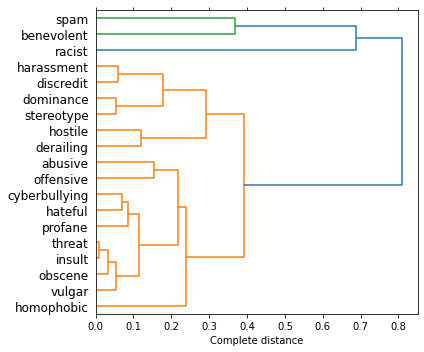

In [227]:
# hierarchical clustering using complete linkage

# use complete linkage and cosine distances to plot the dendrogram
dists1 = 1-simsorted
linkg = hierarchy.linkage(dists1, 'complete') # OPTIONS: ward, single, average, weighted, centroid, median, complete
fig, ax = plt.subplots(figsize=(6, 5))
ax = dendrogram(linkg, orientation="right", labels=uniquecatssorted);
plt.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
plt.xlabel("Complete distance")
plt.tight_layout()
plt.show()